# Introduction

Same as the other, but want to run code here too!

http://adventuresinmachinelearning.com/reinforcement-learning-tutorial-python-keras/



### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
import keras
import time
%matplotlib inline

from keras import backend as K
K.set_image_dim_ordering('th')

/home/kokeeffe/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Main

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import keras as ks
import tensorflow as tf
import time
import random
from keras import Sequential
from keras.layers import InputLayer, Dense, Input
from keras.models import Model
from keras import backend as K
import keras
from keras import optimizers
%matplotlib inline



class DQNagent:
    
    def __init__(self,num_states, num_actions):
        self.gamma = 0.99  #discount factor
        self.alpha = 0.1   #learning rate
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.memory = []
        self.memory_size = 1000
        self.num_states = num_states
        self.num_actions = num_actions
        self.model = self.make_model()
        
        
    def make_model(self):
        """ Instantiate neural net for predicting Q-vals using Keras """
        
        model = Sequential()
        model.add(InputLayer(batch_input_shape=(1, 5)))
        model.add(Dense(10, activation='sigmoid'))
        model.add(Dense(2, activation='linear'))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        return model
        
        
    def vectorize_state(self,state):
        """ Given a state = 0,1,2,3, ...,  return a 1-hot vector
            since Keras works in this format
        """
        return np.identity(self.num_states)[state:state+1]
        
        
    def get_epsilon_iteration(self,episode_number,num_episodes):
        #return max(self.epsilon_min, self.epsilon / (1.0 + episode_number))
            slope = self.epsilon_min - self.epsilon
            epsilon_effective = slope*(episode_number/(1.0*num_episodes)) + self.epsilon
            return epsilon_effective
        
        
    def act(self,state,episode_number = 0, num_episodes = 1):
        
        # epsilon greedy
        epsilon_effective = self.get_epsilon_iteration(episode_number, num_episodes)
        
        if np.random.random() < epsilon_effective:
            action = np.random.choice(range(self.num_actions))
        else:
            action = self.choose_best_action(state)
        return action
                   
                   
    def choose_best_action(self,state_vector):
        Qs = self.model.predict(state_vector)
        action = np.argmax(Qs)
        return action
                   
                   
    def remember(self,event):
        
        if len(self.memory) <= self.memory_size:
            self.memory.append(event)
        else:
            self.memory.pop(0)
            self.memory.append(event)
        
        
    def replay(self,batchsize):
        
        #create minibatch
        indicies = np.random.choice(range(len(self.memory)),batchsize)
        minibatch = [self.memory[i] for i in indicies]

        #Extract states & Qs
        batch_states = np.zeros((batchsize,self.num_states))
        batch_Qs = np.zeros((batchsize,self.num_actions))
        for i,event in enumerate(minibatch):
            state, action, reward, next_state = event
            batch_states[i] = state[0]   #state is a tensor, extract the vector

            #Find Qs -- first grab what I need
            Q_next_vec = self.model.predict(next_state)[0]   #Qs of next state
            Q_target = reward + self.gamma*max(Q_next_vec)   #scalar, for specific action
            Q_target_vec = self.model.predict(state)[0]      #The new Q will be the old, with one update
            Q_target_vec[action] = Q_target                  #Do the update
            Q_target_vec.resize(1,agent.num_actions)         #Turn into tensor, for keras  
            batch_Qs[i] = Q_target_vec

        #Now I have my stack of losses, do the learning
        self.model.fit(batch_states, batch_Qs, epochs=1,verbose=0)
        
        
    def learn(self,event):
        state, action, reward, next_state = event

        #Find Q target
        Q_next_vec = self.model.predict(next_state)[0]   #Qs of next state
        Q_target = reward + self.gamma*max(Q_next_vec)   #scalar, for specific action
        Q_target_vec = self.model.predict(state)[0]      #The new Q will be the old, with one update
        Q_target_vec[action] = Q_target                  #Do the update
        Q_target_vec.resize(1,agent.num_actions)         #Turn into tensor, for keras  
        
        #Now I have my stack of losses, do the learning
        self.model.fit(state, Q_target_vec, epochs=1,verbose=0)
        
        
        
    def print_Qs(self):
        Qs = np.zeros((self.num_states, self.num_actions))
        for i,state in enumerate(range(self.num_states)):
            state_vector = self.vectorize_state(state)
            Qs_temp = self.model.predict(state_vector)[0]
            Qs[i] = Qs_temp
        return Qs

### My code

Score over time: 1393
Final Q-Table Values


array([[3.99351044e+01, 4.00000801e+01],
       [5.82564771e-02, 6.71293885e-02],
       [5.82566671e-02, 6.71295822e-02],
       [5.82569987e-02, 6.71299249e-02],
       [1.64911530e+02, 1.73530792e+02]])

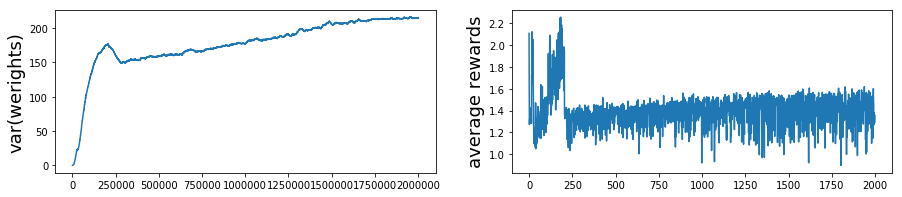

In [21]:
env = gym.make('NChain-v0')


#Environment
env.reset()
num_states = env.observation_space.n
num_actions = env.action_space.n  
num_episodes = 2000
reward_list = []


#Agent
agent = DQNagent(num_states, num_actions)  
agent.gamma = 0.95
agent.epsilon = 0.5
agent.epsilon_min = 0.05
batchsize = 32
var_s = []
decay_factor = 0.999  #freeze the greed



#Train
for episode in range(num_episodes):
    finished = False
    state_zero = 0
    state_vector = agent.vectorize_state(state_zero)
    reward_sum = 0
    agent.epsilon *= decay_factor
    while not finished:
        
        #Main loop
        action = agent.act(state_vector)
        next_state_scalar, reward, finished, _ = env.step(action)
        next_state_vector = agent.vectorize_state(next_state_scalar)
        agent.remember([state_vector,action,reward,next_state_vector])
        state_vector = next_state_vector
        reward_sum += reward
        agent.learn([state_vector,action,reward,next_state_vector])
        
        #Check learning, want to see if the NN is converging
        var = np.var(agent.model.get_weights()[0].flatten())   #variance in weights
        var_s.append(var)
        
        
    #Learn after each episode
    #agent.replay(batchsize)
    var = np.var(agent.model.get_weights()[0].flatten())   #variance in weights
    var_s.append(var) 
    reward_list.append(reward_sum)
    env.reset()
    
#Print stats
print "Score over time: " +  str(sum(reward_list)/num_episodes)

plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(var_s)
plt.ylabel('var(werights)', fontsize=18)
plt.subplot(122)
plt.plot(np.array(reward_list) / 1000.0)
plt.ylabel('average rewards', fontsize=18)
print "Final Q-Table Values"
agent.print_Qs()

### Website code

In [ ]:
from keras import Sequential
from keras.layers import Dense, InputLayer


#Define neural net model
model = Sequential()
model.add(InputLayer(batch_input_shape=(1, 5)))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


#Define environment
env = gym.make('NChain-v0')
num_episodes = 2000


#Train
y = 0.95
eps = 0.5
decay_factor = 0.999
r_avg_list = []
for i in range(num_episodes):
    s = env.reset()
    eps *= decay_factor
    if i % 100 == 0:
        print("Episode {} of {}".format(i + 1, num_episodes))
    done = False
    r_sum = 0
    while not done:
        if np.random.random() < eps:
            a = np.random.randint(0, 2)
        else:
            a = np.argmax(model.predict(np.identity(5)[s:s + 1]))
        new_s, r, done, _ = env.step(a)
        target = r + y * np.max(model.predict(np.identity(5)[new_s:new_s + 1]))
        target_vec = model.predict(np.identity(5)[s:s + 1])[0]
        target_vec[a] = target
        model.fit(np.identity(5)[s:s + 1], target_vec.reshape(-1, 2), epochs=1, verbose=0)
        s = new_s
        r_sum += r
    r_avg_list.append(r_sum / 1000)

Episode 1 of 2000
Episode 101 of 2000
Episode 201 of 2000
Episode 301 of 2000
Episode 401 of 2000
Episode 501 of 2000
Episode 601 of 2000
Episode 701 of 2000
